In [65]:
# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

# Pipeline and model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB

# Score of models
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RED94\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RED94\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
#création d'une blacklist de mots de spam 
dfblacklist = pd.read_csv('blacklist.txt', header=None )
dfblacklist.rename(columns={0:'words'}, inplace=True)
dfblacklistList = dfblacklist['words'].tolist()

In [67]:
#fonction de mise en place du dataset 
def cree_df(url = "SMSSpamCollection.txt"):
    df = pd.read_csv(url, sep='\t', header=None )
    df.rename(columns={0:'type',1:'mail'}, inplace=True)
    return df

In [68]:
#fonction de préparation des données (preprocessing)
def prep(df): 

    #lowercase des message
    df['minuscule']=df['mail'].str.lower()

    #mise en place des tokens des message
    tokenizer = RegexpTokenizer(r"\b\w+\b|\d{2} \d{2} \d{2} \d{2} \d{2}")
    df['token'] = df['minuscule'].apply(lambda x: tokenizer.tokenize(x))

    #ajout d'un stopwords 
    stop = stopwords.words('english')
    df['without_stopwords']=df['token'].apply(lambda x: [word for word in x if word not in stop])

    #ajout d'un stemmer
    stemmer = PorterStemmer()
    df['PorterStemmer'] = df['without_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
    
    #regroupement du traitement des données
    df['clean'] = df['without_stopwords'].apply(lambda x: " ".join(x))
    return df

In [69]:
#fonction d'ajout des features afin d'améliorer la précision des modèles
def features(df):
    
    #ajout d'une feature "longueur du message"
    df['len']=df['mail'].str.len()

    #ajout d'une feature "nombre de mots"
# df['nombre_mots']=df['mail'].str.split().str.len()
    df['nombre_mots']=df['token'].str.len()

    #ajout d'une feature permettant de vérifier si présence d'hypertexte
    pattern = r"http\S+"
    df['http_compt']=df['mail'].apply(lambda x: len(re.findall(pattern, x)))

    #ajout d'une feature permettant de vérifier la présence de chiffre 
    pattern = r"/^[\(]?[\+]?(\d{2}|\d{3})[\)]?[\s]?((\d{6}|\d{8})|(\d{3}[\*\.\-\s]){3}|(\d{2}[\*\.\-\s]){4}|(\d{4}[\*\.\-\s]){2})|\d{8}|\d{10}|\d{12}$/"
    df['phone_compt']=df['mail'].apply(lambda x = True : re.findall(pattern, x) else x = False)

    #ajout d'une feature permettant de vérifier la présence de mail
    pattern = r"[-A-Za-z0-9!#$%&'*+/=?^_`{|}~]+(?:\.[-A-Za-z0-9!#$%&'*+/=?^_`{|}~]+)*@(?:[A-Za-z0-9](?:[-A-Za-z0-9]*[A-Za-z0-9])?\.)+[A-Za-z0-9](?:[-A-Za-z0-9]*[A-Za-z0-9])?"
    df['mail_compt']=df['mail'].apply(lambda x = True : re.findall(pattern, x) else x = False)

    #ajout d'une feature permettant de vérifier la présence de mots blacklisté 
    df['blacklist']=df['token'].apply(lambda x: [ word for word in x if word  in dfblacklistList])
    return df

In [70]:
#fonction permettant la spéaration de la target des autres colonnes (création X et y)

def spliteur(df):
    X = df.drop(columns = ['type','nombre_mots'], axis=1)
    y = df['type']
    return train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [71]:
#fonction création du modèle 
def ModelCreateur(X_train, y_train, classifier):
    
    column_text = X_train.select_dtypes(include=['object']).columns
    column_num = X_train.select_dtypes(exclude=['object']).columns
    
    #Transformation des variables texte
    transfo_text_TFid = Pipeline(steps=[
        ('Tfid', TfidfVectorizer(lowercase=False, decode_error='ignore', analyzer='char_wb', ngram_range=(2, 2)))
        
    ])

    #Transformation des variables numérique
    transfo_text_CountVect = Pipeline(steps=[  
    ('boCountVectorizerw', CountVectorizer(decode_error='ignore', analyzer='char_wb',strip_accents='unicode', ngram_range=(2, 2)))
    ])


#Application des étapes sur tout le dataset
    preparation = ColumnTransformer(
        transformers=[
        ('TFid&data', transfo_text_TFid , 'clean'), #TFIDF ne prend pas de listes comme arguments
        # ('CountVect&data', transfo_text_CountVect , 'clean'),
        
        ('MinMaxScaler&data',MinMaxScaler(), column_num) #['http_compt', 'mail_compt']
        # ('data',StandardScaler(), column_num) #Les classifieurs NB ne prend pas de valeur négatif
        # ('data',RobustScaler(), column_num) #Les classifieurs NB ne prend pas de valeur négatif
        ])
    
    #relie l'algorithme avec le modèle
    model = Pipeline([
    ('vectorizer', preparation),
    ('classifier', classifier)
    ])
    #Fit le modèle
    model.fit(X_train, y_train)
    return model

In [72]:
#fonction permettant de connaître le score de notre modèle
def AfficherScores(y_test, y_pred,model,x):
    
    #affiche l'accuracy du modèle
    print("Accuracy:", accuracy_score(y_test, y_pred))
    #affiche la classification report du modèle
    print(classification_report(y_test, y_pred))
    #affiche les graphiques du modèle
    """plt.hist(model.decision_function(x), bins=50)
    plt.show()"""

In [73]:
# fonction qui affiche la matrice de confusion du modèle
def matrixconf(y_test,y_pred):
    #affiche la matrice de confusion du modèle
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [74]:
#fonction permettant de tester le modèle
def testModel(sms,model):
    #mise en place d'un input
    input_sms     = sms
    #transformation en dataframe afin de l'utiliser correctement
    df_sms        = pd.DataFrame(input_sms)
    df_sms.rename(columns={0:'mail'}, inplace=True)
    #mise en place du preprocessing
    df_sms        = prep(df_sms)
    #mise en place des feature
    df_sms        = features(df_sms)
    #prediction 
    result = model.predict(df_sms)
    return result

In [75]:
#mise en place des modèles
classifier1 = LogisticRegression(solver='liblinear', C=1e3)
classifier2 = KNeighborsClassifier(7)

classifier3 = ComplementNB()                                        
classifier4 = MultinomialNB()                                     
classifier5 = BernoulliNB(force_alpha=True)

classifier6 = SVC()                                     
classifier7 = SVC(gamma=2, C=1, random_state=42)                   

classifier8 = RidgeClassifier(tol=1e-2, solver="sparse_cg")          
classifier9 = RandomForestClassifier(max_depth=200, random_state=42) 
classifier10 = DecisionTreeClassifier()                             

list_model = [classifier1,classifier2,classifier3,classifier4,classifier5,classifier6,classifier7,classifier8,classifier9,classifier10]

                                                   mail  mail_compt
136              I only haf msn. It's yijue@hotmail.com           1
1613  RT-KIng Pro Video Club>> Need help? info@ringt...           1
2313  tddnewsletter@emc1.co.uk (More games from TheD...           1
2548  Text82228>> Get more ringtones, logos and game...           1
3501  Dorothy@kiefer.com (Bank of Granite issues Str...           1
4906  Warner Village 83118 C Colin Farrell in SWAT t...           1
5102  This msg is for your mobile content order It h...           1


<Axes: title={'center': 'mail_compt'}, xlabel='type'>

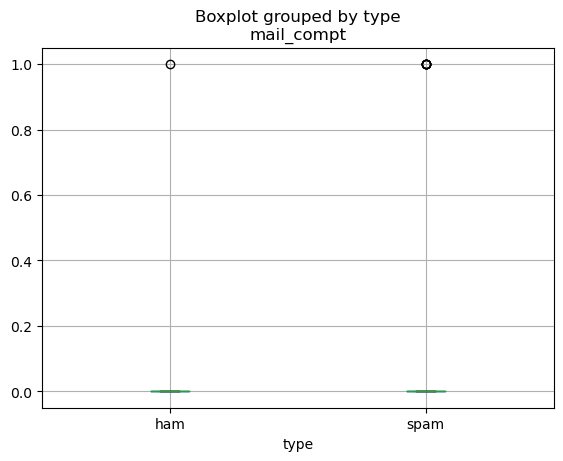

In [83]:
dfModel = cree_df("SMSSpamCollection.txt")
dfModel = prep(dfModel)
dfModel = features(dfModel)

print(dfModel[['mail','mail_compt']].loc[dfModel['mail_compt'] > 0])
dfModel[['type', 'mail_compt']].boxplot(column='mail_compt', by='type')

In [76]:
dfModel = cree_df("SMSSpamCollection.txt")
dfModel = prep(dfModel)
dfModel = features(dfModel)
X_train, X_test, y_train, y_test = spliteur(dfModel)

In [77]:



"""ACP, function transformer et graphique"""

                                                   mail  phone_compt
2     Free entry in 2 a wkly comp to win FA Cup fina...            1
8     WINNER!! As a valued network customer you have...            1
9     Had your mobile 11 months or more? U R entitle...            1
42    07732584351 - Rodger Burns - MSG = We tried to...            2
56    Congrats! 1 year special cinema pass for 2 is ...            1
...                                                 ...          ...
5501  PRIVATE! Your 2003 Account Statement for 07808...            2
5524  You are awarded a SiPix Digital Camera! call 0...            1
5526  PRIVATE! Your 2003 Account Statement for shows...            1
5537  Want explicit SEX in 30 secs? Ring 02073162414...            1
5567  This is the 2nd time we have tried 2 contact u...            1

[411 rows x 2 columns]


NameError: name 'df' is not defined

model utilisé: LogisticRegression(C=1000.0, solver='liblinear')
Accuracy: 0.9904306220095693
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       1.00      0.93      0.96       224

    accuracy                           0.99      1672
   macro avg       0.99      0.97      0.98      1672
weighted avg       0.99      0.99      0.99      1672

model utilisé: KNeighborsClassifier(n_neighbors=7)
Accuracy: 0.9826555023923444
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       0.99      0.88      0.93       224

    accuracy                           0.98      1672
   macro avg       0.99      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672

model utilisé: ComplementNB()
Accuracy: 0.958732057416268
              precision    recall  f1-score   support

         ham       0.98      0.97      0.98      1448
      

c:\Users\RED94\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\RED94\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\RED94\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model utilisé: SVC(C=1, gamma=2, random_state=42)
Accuracy: 0.979066985645933
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       0.98      0.86      0.92       224

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672

model utilisé: RidgeClassifier(solver='sparse_cg', tol=0.01)
Accuracy: 0.9874401913875598
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       1.00      0.91      0.95       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672

model utilisé: RandomForestClassifier(max_depth=200, random_state=42)
Accuracy: 0.9850478468899522
              precision    recall  f1-score   support

         ham       0.98 

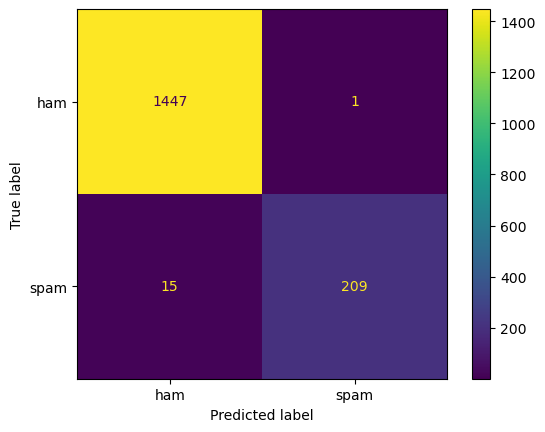

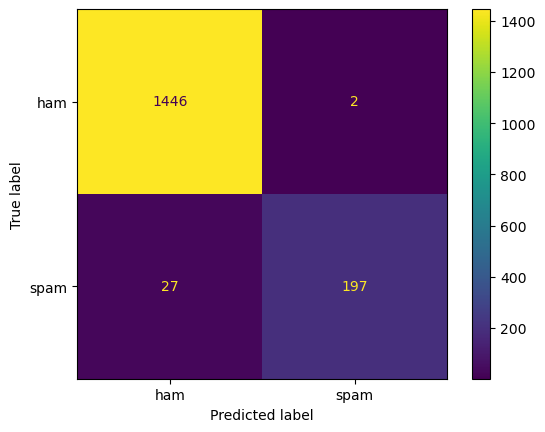

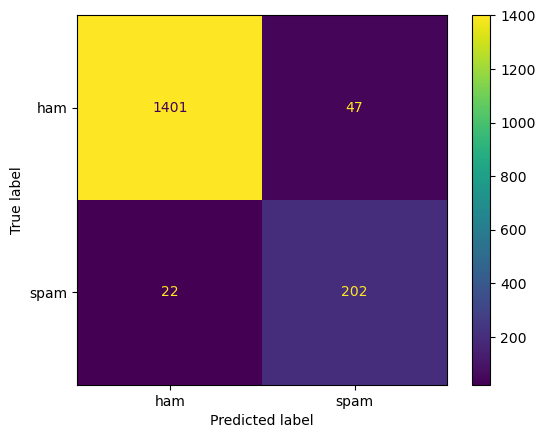

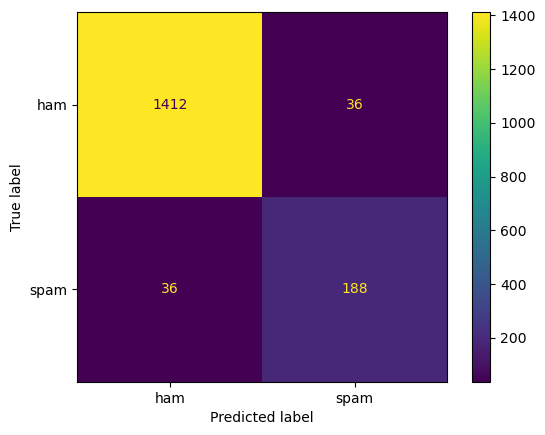

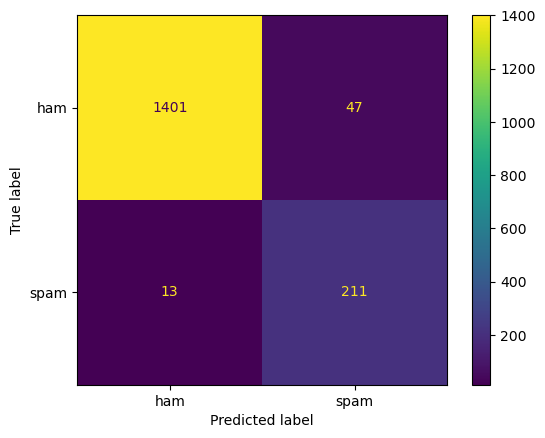

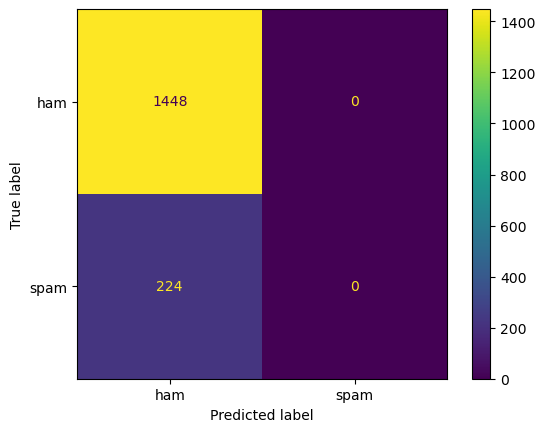

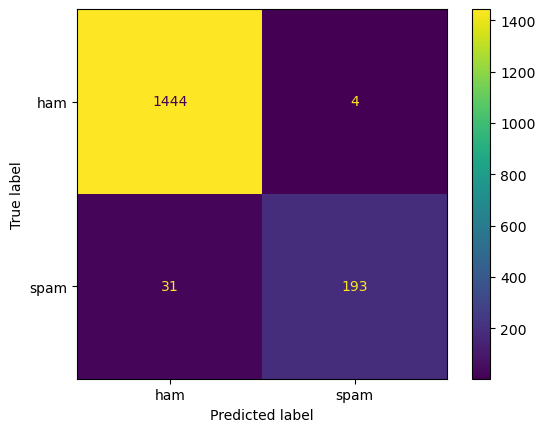

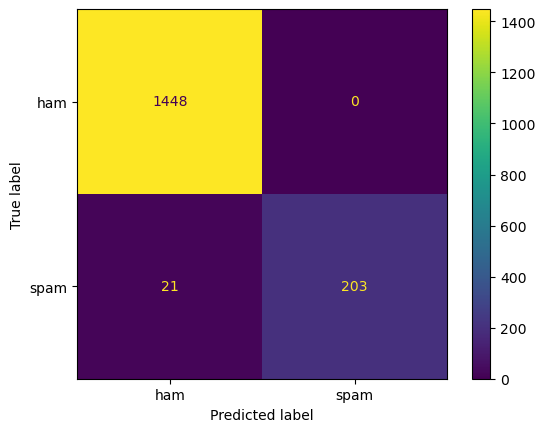

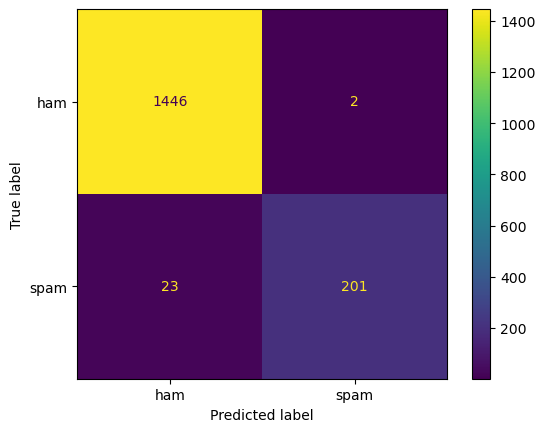

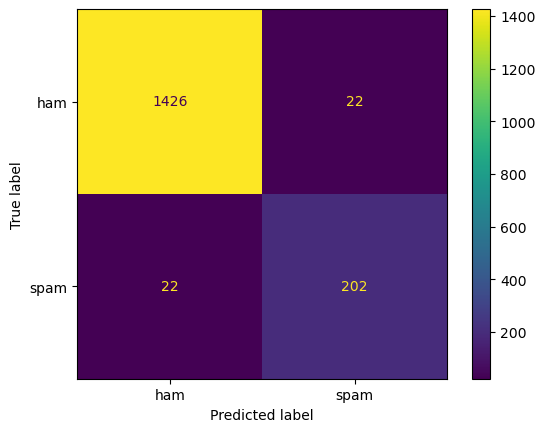

In [ ]:
#input =  ['Hi Nick. This is to remind you about the $75 minimum payment on your credit card ending in XXXX. Payment is due on 01/01. Pls visit order.com to make your payment']
for i in list_model:
    model_lm=ModelCreateur(X_train, y_train, i)
    print('model utilisé:', i)
    y_pred = testModel(X_test,model_lm)
    matrixconf(y_test,y_pred)
    AfficherScores(y_test, y_pred,model_lm,X_test)